# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>
- TAs: Tong Zeng <tozeng@syr.edu>, Priya Matnani <psmatnan@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [39]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Servo analysis

In this assignment, you will continue the analysis we started in class of the Servo dataset.

# Servo data analysis

```console
1. Title: Servo Data

2. Sources
   (a) Created by: Karl Ulrich (MIT) in 1986
   (b) Donor: Ross Quinlan
   (c) Date: May 1993

3. Past Usage:

   1.  Quinlan, J.R., "Learning with continuous classes", Proc. 5th Australian
       Joint Conference on AI (eds A. Adams and L. Sterling), Singapore: World
       Scientific, 1992
 
   2.  Quinlan, J.R., "Combining instance-based and model-based learning",
       Proc. ML'93 (ed P.E. Utgoff), San Mateo: Morgan Kaufmann 1993
 
       Results on 10-way cross-validation:
 
       Method			Average		Relative
       ------			 |Err|		 Error
 				-------		--------
 
       Guessing mean		  1.15		  1.00
       Instance-based		   .52		   .26
       Regression		   .86		   .49
       Model trees		   .45		   .29
       Neural nets (G. Hinton)	   .30		   .11
       Regression+instances	   .48		   .20
       Model trees+instances	   .30		   .17
       NN+instances		   .29		   .11
 
4. Relevant Information:

   Ross Quinlan:

   This data was given to me by Karl Ulrich at MIT in 1986.  I didn't 
   record his description at the time, but here's his subsequent (1992) 
   recollection:
 
     "I seem to remember that the data was from a simulation of a servo
     system involving a servo amplifier, a motor, a lead screw/nut, and a
     sliding carriage of some sort.  It may have been on of the
     translational axes of a robot on the 9th floor of the AI lab.  In any
     case, the output value is almost certainly a rise time, or the time
     required for the system to respond to a step change in a position set
     point."
 
   (Quinlan, ML'93)

   "This is an interesting collection of data provided by Karl 
    Ulrich.  It covers an extremely non-linear phenomenon - predicting the 
    rise time of a servomechanism in terms of two (continuous) gain settings
    and two (discrete) choices of mechanical linkages."

5. Number of Instances: 167

6. Number of Attributes: 4 + numeric class attribute

7. Attribute information:

   1. motor: A,B,C,D,E
   2. screw: A,B,C,D,E
   3. pgain: 3,4,5,6
   4. vgain: 1,2,3,4,5
   5. class: 0.13 to 7.10

8. Missing Attribute Values: None
```

In [40]:
# Load the data
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/servo/servo.data"
servo_df = spark.createDataFrame(pd.read_csv(data_url, 
            sep=',', 
            header=None,
            names=['motor', 'screw', 'pgain', 'vgain', 'rise_time']))

# 1. Explore the data

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe

Create a dataframe `servo_sample_df` with the first 20 rows of `servo_df`.

In [41]:
# create `servo_sample_df`
# YOUR CODE HERE
servo_sample_df = servo_df.limit(20)
#raise NotImplementedError()

In [42]:
# 2 pts - right number of rows
np.testing.assert_equal(servo_sample_df.count(), 20)

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `pgain` vs `rise_time`

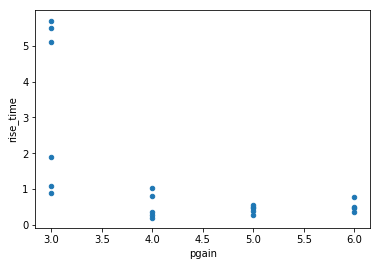

In [43]:
# YOUR CODE HERE
servo_sample_df.toPandas().plot(x='pgain', y='rise_time', kind='scatter')
#raise NotImplementedError()

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `vgain` vs `rise_time`

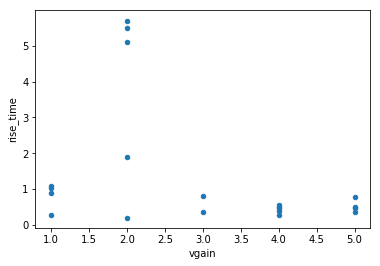

In [44]:
# YOUR CODE HERE
servo_sample_df.toPandas().plot(x='vgain', y='rise_time', kind='scatter')
#raise NotImplementedError()

## Perform correlations between vgain-rise time, pgain-rise time, and vgain-pgain

Create a `servo_corr_df` dataframe that contains the correlations between `vgain` and `rise_time` as a column `corr_vgain_rise_time`, between `pgain` and `rise_time` as `corr_pgain_rise_time`, and `vgain` and `pgain` as `corr_vgain_pgain`.

In [45]:
# create `servo_corr_df` here
# correlations
servo_corr_df = servo_df.select(fn.corr('vgain', 'rise_time').alias('corr_vgain_rise_time')
                                ,fn.corr('pgain', 'rise_time').alias('corr_pgain_rise_time')
                                ,fn.corr('pgain', 'vgain').alias('corr_vgain_pgain'))
servo_corr_df.show()
#raise NotImplementedError()

+--------------------+--------------------+------------------+
|corr_vgain_rise_time|corr_pgain_rise_time|  corr_vgain_pgain|
+--------------------+--------------------+------------------+
|-0.36438266626914595| -0.5981287119612234|0.8122683058183875|
+--------------------+--------------------+------------------+



In [46]:
## 7 pts
np.testing.assert_equal(set(servo_corr_df.columns), 
                        {'corr_pgain_rise_time', 'corr_vgain_pgain', 'corr_vgain_rise_time'})
np.testing.assert_almost_equal(list(servo_corr_df.first().asDict().values()),
                               [-0.36438266626914595, -0.5981287119612234, 0.8122683058183874], decimal=3)

## Compute mean rise_time for different motors and screws

Create `motor_rise_time_df` with the column `motor` and `avg_rise_time`, where `avg_rise_time` is the average rise time for a motor. Sort the resulting dataframe from highest to lowest average rise time.

In [47]:
# YOUR CODE HERE
motor_rise_time_df = servo_df.groupBy('motor').agg(fn.mean('rise_time').alias('avg_rise_time')).orderBy('avg_rise_time', ascending = False)
motor_rise_time_df.show()
#raise NotImplementedError()

+-----+------------------+
|motor|     avg_rise_time|
+-----+------------------+
|    A| 1.761110668888889|
|    B|1.6819423677777776|
|    C|1.2540610067500002|
|    E|1.1448932081818182|
|    D|0.9176125145454544|
+-----+------------------+



In [48]:
# 3 pts
np.testing.assert_array_equal(np.array(motor_rise_time_df.rdd.map(lambda x: list(x.asDict().values())).collect()),
                                  [['A', '1.761110668888889'],
       ['B', '1.6819423677777776'],
       ['C', '1.2540610067500002'],
       ['E', '1.1448932081818182'],
       ['D', '0.9176125145454544']])

Create `screw_rise_time_df` with the column `screw` and `avg_rise_time` sorted from highest to lowest average rise time.

In [49]:
# YOUR CODE HERE
screw_rise_time_df = servo_df.groupBy('screw').agg(fn.mean('rise_time').alias('avg_rise_time')).orderBy('avg_rise_time', ascending = False)
screw_rise_time_df.show()
#raise NotImplementedError()

+-----+------------------+
|screw|     avg_rise_time|
+-----+------------------+
|    A| 1.768461212142857|
|    B|1.3919625091428571|
|    C|1.2485862280645161|
|    E|1.2256432917241378|
|    D|1.1612471173333332|
+-----+------------------+



In [50]:
# 3 pts
np.testing.assert_array_equal(np.array(screw_rise_time_df.rdd.map(lambda x: list(x.asDict().values())).collect()),
                                  [['A', '1.768461212142857'],
       ['B', '1.3919625091428571'],
       ['C', '1.2485862280645161'],
       ['E', '1.2256432917241378'],
       ['D', '1.1612471173333332']])

# Feature engineering

## Dummy variables for motors and screws
Create a dataframe `dummy_df` with columns `motor` and `screw` as dummy variables, and columns `vgain`, `pgain`, and `rise_time`. Use motor D and screw C as the baselines and name the dummy variables `motor_A` for motor `A` and so on. Follow a similar pattern for screw. The dataframe `dummy_df` should not contain the columns `motor` and `screw` but only their dummy variable representations. **All column types should be float or integer.**

In [51]:
# create dummy_df below
# YOUR CODE HERE
# code here
dummy_df = servo_df.select(
               (fn.col('motor')=='A').cast('float').alias('motor_A'),
               (fn.col('motor')=='B').cast('float').alias('motor_B'),
               (fn.col('motor')=='C').cast('float').alias('motor_C'),
               (fn.col('motor')=='E').cast('float').alias('motor_E'),
               (fn.col('screw')=='A').cast('float').alias('screw_A'),
               (fn.col('screw')=='B').cast('float').alias('screw_B'),
               (fn.col('screw')=='D').cast('float').alias('screw_D'),
               (fn.col('screw')=='E').cast('float').alias('screw_E'),
               fn.col('pgain').cast('integer'),
               fn.col('vgain').cast('integer'),
               fn.col('rise_time').cast('float')            
               )
dummy_df.show()
# raise NotImplementedError()

+-------+-------+-------+-------+-------+-------+-------+-------+-----+-----+----------+
|motor_A|motor_B|motor_C|motor_E|screw_A|screw_B|screw_D|screw_E|pgain|vgain| rise_time|
+-------+-------+-------+-------+-------+-------+-------+-------+-----+-----+----------+
|    0.0|    0.0|    0.0|    1.0|    0.0|    0.0|    0.0|    1.0|    5|    4|0.28125095|
|    0.0|    1.0|    0.0|    0.0|    0.0|    0.0|    1.0|    0.0|    6|    5| 0.5062525|
|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    1.0|    0.0|    4|    3|0.35625148|
|    0.0|    1.0|    0.0|    0.0|    1.0|    0.0|    0.0|    0.0|    3|    2|  5.500033|
|    0.0|    0.0|    0.0|    0.0|    0.0|    1.0|    0.0|    0.0|    6|    5|0.35625148|
|    0.0|    0.0|    0.0|    1.0|    0.0|    0.0|    0.0|    0.0|    4|    3| 0.8062546|
|    0.0|    0.0|    1.0|    0.0|    1.0|    0.0|    0.0|    0.0|    3|    2|  5.100014|
|    1.0|    0.0|    0.0|    0.0|    1.0|    0.0|    0.0|    0.0|    3|    2| 5.7000422|
|    0.0|    0.0|    

In [52]:
# 3 pts
np.testing.assert_equal(len(dummy_df.columns), 11)
np.testing.assert_equal(dummy_df.select(fn.sum('motor_A')).first()['sum(motor_A)'], 36)
np.testing.assert_equal(dummy_df.select(fn.sum('screw_A')).first()['sum(screw_A)'], 42)

##  Apply min-max scaling to  vgain and pgain
Starting from `dummy_df` create a dataframe `mm_dummy_df` that replaces `pgain` and `vgain` by the min-max scaled values of them. The new columns should be named `mm_pgain` and `mm_vgain`. `pgain` and `vgain` should not appear in `mm_dummy_df`.

The value of a feature $x$ is scaled with min-max if you apply the following to it

$$\text{minmax}(x_i) = \frac{x_i - \min(x)}{\max(x) - \min(x)}$$

where $\min(x)$ and $\max(x)$ are the minimum and maximum values of $x$ across all the dataset.

In [53]:
pgain_stat = dummy_df.select(fn.min('pgain').alias('min_pgain'),fn.max('pgain').alias('max_pgain')).first()
vgain_stat = dummy_df.select(fn.min('vgain').alias('min_vgain'),fn.max('vgain').alias('max_vgain')).first()

In [54]:
# create `mm_dummy_df` here
# YOUR CODE HERE
mm_dummy_df = dummy_df.withColumn('mm_pgain',(fn.col('pgain')-pgain_stat['min_pgain'])/(pgain_stat['max_pgain']-pgain_stat['min_pgain'])
                                  ).drop("pgain")
mm_dummy_df = mm_dummy_df.withColumn('mm_vgain',(fn.col('vgain')-vgain_stat['min_vgain'])/(vgain_stat['max_vgain']-vgain_stat['min_vgain'])
                                 ).drop('vgain')

mm_dummy_df = mm_dummy_df.select('mm_pgain',
 'mm_vgain',
 'motor_A',
 'motor_B',
 'motor_C',
 'motor_E',
 'rise_time',
 'screw_A',
 'screw_B',
 'screw_D',
 'screw_E')
mm_dummy_df.show                           
#raise NotImplementedError()

<bound method DataFrame.show of DataFrame[mm_pgain: double, mm_vgain: double, motor_A: float, motor_B: float, motor_C: float, motor_E: float, rise_time: float, screw_A: float, screw_B: float, screw_D: float, screw_E: float]>

In [55]:
np.testing.assert_equal(set(mm_dummy_df.columns), 
                        {'mm_pgain',
 'mm_vgain',
 'motor_A',
 'motor_B',
 'motor_C',
 'motor_E',
 'rise_time',
 'screw_A',
 'screw_B',
 'screw_D',
 'screw_E'})
# test limits
np.testing.assert_equal(mm_dummy_df.select(fn.max('mm_vgain')).first()['max(mm_vgain)'], 1.0)
np.testing.assert_equal(mm_dummy_df.select(fn.min('mm_vgain')).first()['min(mm_vgain)'], 0.0)
np.testing.assert_equal(mm_dummy_df.select(fn.max('mm_pgain')).first()['max(mm_pgain)'], 1.0)
np.testing.assert_equal(mm_dummy_df.select(fn.min('mm_pgain')).first()['min(mm_pgain)'], 0.0)

# Model comparison

In the next set of questions, you will use the splits below to fit, validate, and estimate the generalization error of your models. The `randomSplit` is called with a seed so that it does not change from what the professor used.

In [56]:
training_df, validation_df, testing_df = mm_dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  111
# points in validation:  42
# points in testing:  14


## Propose three regression models

In the next section, you will choose the best model to explain the data in `servo_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `pgain`

Create a pipeline that takes *pgain* as a feature to predict *rise time* and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `mm_dummy_df` in which the raw feature `pgain` may or may not have been feature engineered. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [57]:
# create `pipe_model1` below
# YOUR CODE HERE
va = feature.VectorAssembler(inputCols = ['mm_pgain'], outputCol = 'features')
lr = regression.LinearRegression(featuresCol = 'features', labelCol = 'rise_time')
pipe = Pipeline(stages = [va, lr])
pipe_model1 = pipe.fit(training_df)
predictions1_df = pipe_model1.transform(validation_df)
# raise NotImplementedError()

In [58]:
# (5 pts)
np.testing.assert_equal(type(pipe_model1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model1.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model1.stages[1].coefficients.shape, (1,))

### Model 2: Fit model with only `vgain`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [59]:
# YOUR CODE HERE
va = feature.VectorAssembler(inputCols = ['mm_vgain'], outputCol = 'features')
lr = regression.LinearRegression(featuresCol = 'features', labelCol = 'rise_time')
pipe = Pipeline(stages = [va, lr])
pipe_model2 = pipe.fit(training_df)
predictions2_df = pipe_model2.transform(validation_df)
#raise NotImplementedError()

In [60]:
# (5 pts)
np.testing.assert_equal(type(pipe_model2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model2.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model2.stages[1].coefficients.shape, (1,))

### Model 3: Fit model with only motor, screw, pgain, and vgain

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: motor, screw, pgain, and vgain. Choose the columns from `mm_dummy_df` appropriately.

In [61]:
# create `pipe_model2` below
# YOUR CODE HERE
va = feature.VectorAssembler(inputCols = ['motor_A','motor_B','motor_C','motor_E','screw_A','screw_B','screw_D','screw_E'
                                          ,'mm_pgain','mm_vgain'], outputCol = 'features')
lr = regression.LinearRegression(featuresCol = 'features', labelCol = 'rise_time')
pipe = Pipeline(stages = [va, lr])
pipe_model3 = pipe.fit(training_df)
predictions3_df = pipe_model3.transform(validation_df)
#raise NotImplementedError()

In [62]:
# (5 pts)
np.testing.assert_equal(type(pipe_model3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model3.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model3.stages[1].coefficients.shape, (10,))

# Compare models

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only with column `rmse`

In [63]:
# create rmse1_df, rmse2_df, and rmse3_df dataframes below
# YOUR CODE HERE
rmse1_df = predictions1_df.select((fn.col('prediction')-fn.col('rise_time')).alias('Error')).\
    select(fn.sqrt(fn.avg(fn.col('Error')**2)).alias('rmse')) 

rmse2_df = predictions2_df.select((fn.col('prediction')-fn.col('rise_time')).alias('Error')).\
    select(fn.sqrt(fn.avg(fn.col('Error')**2)).alias('rmse')) 

rmse3_df = predictions3_df.select((fn.col('prediction')-fn.col('rise_time')).alias('Error')).\
    select(fn.sqrt(fn.avg(fn.col('Error')**2)).alias('rmse')) 

#raise NotImplementedError()

In [64]:
# display the answers here
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+------------------+
|              rmse|
+------------------+
|1.4413698814003613|
+------------------+

+------------------+
|              rmse|
+------------------+
|1.6435655058934688|
+------------------+

+------------------+
|              rmse|
+------------------+
|1.1801063539757934|
+------------------+



In [65]:
# (5 pts)
np.testing.assert_equal(rmse1_df.count(), 1)
np.testing.assert_equal(rmse2_df.count(), 1)
np.testing.assert_equal(rmse3_df.count(), 1)
np.testing.assert_equal(rmse1_df.columns, ['rmse'])
np.testing.assert_equal(rmse2_df.columns, ['rmse'])
np.testing.assert_equal(rmse3_df.columns, ['rmse'])

Assign the best cross validated model to a variable `best_model` below

In [66]:
# assign best model (the best pipeline transformer) to a variable best_model below
# YOUR CODE HERE
#Model pipe_model3 is best because it has the least rmse value 
best_model = pipe_model3
#raise NotImplementedError()

In [67]:
# (5 pts)
np.testing.assert_equal(type(best_model), pyspark.ml.pipeline.PipelineModel)

### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [68]:
# create rmse_best_df
# YOUR CODE HERE
predictions_test_df = best_model.transform(testing_df)
rmse_best_df = predictions_test_df.select((fn.col('prediction')-fn.col('rise_time')).alias('Error')).\
    select(fn.sqrt(fn.avg(fn.col('Error')**2)).alias('rmse')) 
#raise NotImplementedError()

In [69]:
# (3 pts)
np.testing.assert_equal(rmse_best_df.count(), 1)
np.testing.assert_equal(rmse_best_df.columns, ['rmse'])

(2 pts) What is the best estimated generalization performance of the best model? Answer in the cell below

In [70]:
# YOUR CODE HERE
rmse_best_df.show()
#raise NotImplementedError()

+-----------------+
|             rmse|
+-----------------+
|1.223813802007709|
+-----------------+



# Do inference with best model

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and fit it to the **entire training data** (all of `mm_dummy_df`).

In [71]:
# create `pipe_model_best` below
# YOUR CODE HERE
pipe_model_best = Pipeline(stages=[
  feature.VectorAssembler(inputCols = ['motor_A','motor_B','motor_C','motor_E','screw_A','screw_B',
                                          'screw_D','screw_E','mm_pgain','mm_vgain'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='rise_time')  
]).fit(mm_dummy_df)


print("coefficients pipe_model_best", pipe_model_best.stages[1].coefficients)

#raise NotImplementedError()

coefficients pipe_model_best [1.4302994632639758,1.351131153495935,1.163731460794015,0.7438666460826988,1.0825045814846244,0.3617844395426156,-0.12295758298117612,-0.08318359374321067,-4.930585091255738,2.2679909921423884]


In [72]:
# (3 pts) check that the model was fitted correctly
np.testing.assert_equal(type(pipe_model_best.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model_best.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model_best.stages[1].coefficients.shape, (10,))

**(4 pts)** Since all features on `mm_dummy_df` were standardized to be within the same range (e.g., 0 and 1), we can compare their importance directly by looking at the coefficients of the linear regression. Taking motor D and screw C as the baseline, what are the top 2 most important features for *increasing rise time* and the top 2 most important features for *decreasing rise time*? Answer below with code and comments to support your answer

In [73]:
# YOUR CODE HERE
print("coefficients pipe_model_best", pipe_model_best.stages[1].coefficients)
# If we observe the coeffiecients (multiplication factor) for vgain (mm_vgain), motor A increase the rise time 
# as they have highest coeffiecient. For features pgain (mm_pgain) and screw D have the higest negative i.e. lowest coeffiecient
# , and thus it is responsible for decreasing the rise time.
# raise NotImplementedError()

coefficients pipe_model_best [1.4302994632639758,1.351131153495935,1.163731460794015,0.7438666460826988,1.0825045814846244,0.3617844395426156,-0.12295758298117612,-0.08318359374321067,-4.930585091255738,2.2679909921423884]
